In [21]:
# -*- coding: utf-8 -*-
# %automatically find the limits of latitude & longitute
# https://blog.csdn.net/htbeker/article/details/79417959# reindex
import pygrib
import pandas as pd
import numpy as np
import os, time, datetime
from datetime import datetime
import glob
import matplotlib.pyplot as plt
from matplotlib import cm as CM
from matplotlib.colors import LogNorm,PowerNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
def get_distances(lats1,lons1,lats2,lons2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    earth_radius = 6371 #3958.75 miles
    #lats1, lats2 =locs_1[:,0], locs_2[:,0]
    #lons1, lons2 =locs_1[:,0], locs_2[:,0]
    #print(lats1)
    #print(lats2)
    lat_dif = np.radians(lats1 - lats2)
    long_dif = np.radians(lons1 - lons2)

    sin_d_lat = np.sin(lat_dif / 2.)
    sin_d_long = np.sin(long_dif / 2.)
    # haversine
    step_1 = (sin_d_lat ** 2) + (sin_d_long ** 2) * np.cos(np.radians(lats1)) * np.cos(np.radians(lats2))
    step_2 = 2 * np.arctan2(np.sqrt(step_1), np.sqrt(1-step_1))
    dist = step_2 * earth_radius

    return dist


In [3]:
def Tb_filtering(lat_pic,lon_pic,t_base,dist_km,Tlcl,HGT,Lndsfc_flag,thresh_neb):
    '''
    This function recieves 3 vectors of lat lon tbase and its output is Tbase
    HGT = ccn_data["HGT"]#;%longitude col = 21
    HGT = ccn_data["HGT"]#;%longitude col = 21
    with filtered Tbase that are too different from their environment.
    more adjustments : no. of nebs is constraining the number of neighbouring
    cells in order to make the calculation.
    '''
    filter_nebs = np.ones(t_base.shape[0])#[]
    filter_iso=filter_nebs
    lowest_dists=[]
    print(len(lat_pic))
    for i in range(0,len(lat_pic)):
        print(i)
        #print(lat_pic)
        arclen= get_distances(lat_pic[i],lon_pic[i],lat_pic[:],lon_pic[:])#calc its dist from neighbours
        lowest_dists = sorted(arclen) #sort the distance from other points (degrees)
        temp_dist=np.array(lowest_dists)<dist_km
        #temp100=np.extract(np.array(lowest_dists)<100,lowest_dists)
        HGT_75th=np.percentile(temp_dist,75)
        hgt_sd = np.nanstd(temp_dist)
        temp_tbase=np.extract(temp_dist,t_base)
        Tbase_median=np.nanmedian(temp_tbase)
        print(Tbase_median)
        no_nebs = len(temp_dist & np.isnan(t_base)==0)#no of nebs
        if no_nebs>thresh_neb: #comparison of TBase for excluding points
            if (t_base[i]-Tbase_median<-3) & (HGT[i]-HGT_75th<hgt_sd) & (Lndsfc_flag[i]==1): #there are differences that are not related to topography
                filter_nebs[i] = np.NaN
            elif (t_base[i]-Tbase_median<-3) & (Lndsfc_flag[i]== 0):
                filter_nebs[i] = np.NaN
        elif abs(Tlcl[i]-t_base[i])>5 & (no_nebs<=thresh_neb): #the point is isolated and has a large difference with LCL
            filter_iso[i] = np.NaN
        #print(t_base)
        #print(filter_nebs)
        #print(filter_iso)
        Tb_filtering = t_base*filter_nebs*filter_iso
        return Tb_filtering


In [34]:
def plotMap():
    #Set the projection information Cannot label gridlines on a LambertConformal plot. Only PlateCarree and Mercator plots are currently supported.
##add shapefile
    # add borders, coastline, rivers, lakes, and provinces of China
    proj = ccrs.PlateCarree(central_longitude=118.8)
    #Create a figure with an axes object on which we will plot. Pass the projection to that axes.
    fig, ax = plt.subplots(subplot_kw=dict(projection=proj))
    
    #Zoom in
    ax.set_extent([100, 130, 20, 50])

    #Add map features
    ax.add_feature(cfeature.LAND, facecolor='0.9') #Grayscale colors can be set using 0 (black) to 1 (white)
    ax.add_feature(cfeature.LAKES, alpha=0.9)  #Alpha sets transparency (0 is transparent, 1 is solid)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), zorder=10, linestyle=':') # high resolution
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), zorder=10, linestyle=':') # mediate resolution
    ax.add_feature(cfeature.RIVERS) # low resolution
    ax.stock_img()

    #We can use additional features from Natural Earth (http://www.naturalearthdata.com/features/)
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m',facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray', zorder=10)
    fname = '/data/c03n02/cliu/data/map/CHN_adm2.shp'
    adm1_shapes = list(Reader(fname).geometries())
    ax.add_geometries(adm1_shapes, crs=ccrs.PlateCarree(),edgecolor='black', facecolor='none', alpha=0.5,linewidths=0.5)
    plt.scatter(lon,lat,#latlon=True,
          c=ccn, s=aqi,
          cmap=CM.get_cmap('rainbow',40),norm=PowerNorm(gamma=1./2.),alpha=0.5,transform=ccrs.PlateCarree()) #Normalize a given value to the 0-1 range on a log scale
    #Add lat/lon gridlines every 20° to the map
    plt.colorbar(label=r'CCN/cm^3')
    plt.clim(0,5000)
# make legend with dummy points
    for a in [-100,-75,-50,-25,0,25]:
        plt.scatter([], [], c='k', alpha=0.5, s=(a+105),
                label=str(a)+'')
#plt.legend(scatterpoints=1, frameon=False,
#           labelspacing=1, loc='lower left',title= 'AQI',
#           bbox_to_anchor=(,0),ncol=5)
    plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left',title= 'temp',
           bbox_to_anchor=(-0.05,-0.2,1,0.2),
           mode="expand", borderaxespad=0, ncol=7)
    plt.title(str(times)[0:10], fontsize=20)
    return fig, ax

In [43]:
def plotMap1():
    #Set the projection information Cannot label gridlines on a LambertConformal plot. Only PlateCarree and Mercator plots are currently supported.
##add shapefile
    # add borders, coastline, rivers, lakes, and provinces of China
    proj = ccrs.PlateCarree(central_longitude=118.8)
    #Create a figure with an axes object on which we will plot. Pass the projection to that axes.
    fig, ax = plt.subplots(figsize=(11.8, 8),subplot_kw=dict(projection=proj))
    ax.background_img(name='BM', resolution='high')
    #Zoom in
    ax.set_extent([100, 130, 20, 50])

    #Add map features
    ax.add_feature(cfeature.LAND, facecolor='0.9') #Grayscale colors can be set using 0 (black) to 1 (white)
    ax.add_feature(cfeature.LAKES, alpha=0.9)  #Alpha sets transparency (0 is transparent, 1 is solid)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), zorder=10, linestyle=':') # high resolution
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), zorder=10, linestyle=':') # mediate resolution
    ax.add_feature(cfeature.RIVERS) # low resolution
    #ax.stock_img()

    #We can use additional features from Natural Earth (http://www.naturalearthdata.com/features/)
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m',facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray', zorder=10)
    fname = '/data/c03n02/cliu/data/map/CHN_adm2.shp'
    adm1_shapes = list(Reader(fname).geometries())
    ax.add_geometries(adm1_shapes, crs=ccrs.PlateCarree(),edgecolor='black', facecolor='none', alpha=0.5,linewidths=0.5)
    plt.scatter(lon,lat,#latlon=True,
          c=ccn, s=aqi,
          cmap=CM.get_cmap('rainbow',40),norm=PowerNorm(gamma=1./2.),alpha=0.5,transform=ccrs.PlateCarree()) #Normalize a given value to the 0-1 range on a log scale
    #Add lat/lon gridlines every 20° to the map
    plt.colorbar(label=r'CCN/cm^3')
    plt.clim(0,5000)
# make legend with dummy points
    for a in [-60,-50,-40,-30,-20,-10,0,10,20]:
        plt.scatter([], [], c='k', alpha=0.5, s=(2*a+140),
                label=str(a)+'')
#plt.legend(scatterpoints=1, frameon=False,
#           labelspacing=1, loc='lower left',title= 'AQI',
#           bbox_to_anchor=(,0),ncol=5)
    plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left',title= 'temp',
           bbox_to_anchor=(-0.02,-0.18,1,0.2),
           mode="expand", borderaxespad=0, ncol=5)
    plt.title(str(times)[0:10], fontsize=20)
    return fig, ax

In [13]:
%matplotlib inline

AUTO_5MINS_NPP_MicroPhys_20150801_0442_Table.txt
RangeIndex(start=0, stop=568, step=1)
568
568
0
20.5


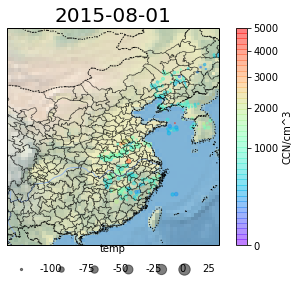

In [27]:
for f in glob.glob("AUTO_5MINS_NPP_MicroPhys_20150801*Table.txt"):
#for f in glob.glob("AUTO_5MINS_NPP_MicroPhys_20150804_0526_Table.txt"):
#for f in glob.glob("AUTO_5MINS_NPP_MicroPhys_20150801_0442_Table.txt"):
    print(f)
    #times=pd.to_datetime(f[28:36],format='%Y%m%d')
    times=pd.to_datetime(f[25:33],format='%Y%m%d')
    ccn_data = pd.read_csv(f, sep='\s+',skiprows=0,header=0,na_values=[-99,-9999])
    #filtering of bad data unique to each dataset
    ccn_data=ccn_data[ccn_data["CCN_1.0_cm3"]>0] #excluding negative values
    ccn_data=ccn_data[ccn_data["CCN_1.0_cm3"]<5000]
    ccn_data=ccn_data[(ccn_data["satz"]>=-15) & (ccn_data["satz"]<=50)]#excluding bad satz
    ccn_data=ccn_data[(ccn_data["Hcbs1.0"]>=0) & (ccn_data["Hcbs1.0"]<=4000)]#cloud base height above surface
    ccn_data=ccn_data[(ccn_data["SS_1.0_mg"]>=0) & (ccn_data["SS_1.0_mg"]<=1.5)]#

    # Convective clouds detection
    ccn_data=ccn_data[ccn_data["Mean_Cv"]<0]
    ccn_data=ccn_data[ccn_data["Frac_CLD"]<0.95]
    ccn_data=ccn_data[ccn_data["Frac_Re"]>0.004]
    ccn_data=ccn_data[ccn_data["Mean_Re"]<35]
    ccn_data=ccn_data[ccn_data["Tskin"]!=np.NaN]
    ccn_data=ccn_data[ccn_data["Tcb1.0"]!=np.NaN]
    ccn_data=ccn_data[ccn_data["Retop1.0"]!=np.NaN]
    ccn_data=ccn_data.reset_index(drop=True)# reset index
    #clearing pixels with Tbase that is different from its environment:
    #getting more criterias for the calculation and clearing them from nans
    lat_pic = ccn_data["lat"]#;%latitude col = 4
    lon_pic = ccn_data["lon"]#;%longitude col = 5
    print(lat_pic.index)
    print(len(lat_pic))
    t_base = ccn_data["Tcb1.0"]#;%longitude col = 34
    Tlcl = ccn_data["T_LCL_nc"]#;%longitude col = 30
    HGT = ccn_data["HGT"]#;%longitude col = 21
    Lndsfc_flag = ccn_data["L/S"]#;%longitude col = 22
    #loc_pic = np.array([[lat_pic,lon_pic]])
    #loc_pic = np.array([[34, -81]])
    #lat_min = lat_pic.min()
    #lat_max = lat_pic.max()
    #lon_min = lon_pic.min()
    #lon_max = lat_pic.max()

    Tb_f=Tb_filtering(lat_pic,lon_pic,t_base,110,Tlcl,HGT,Lndsfc_flag,10)#calc its dist from neighbours
    #print(Tb_f)
    ccn_data["Tb_f"]=Tb_f
    ccn_data=ccn_data[ccn_data["Tb_f"]!=np.NaN]
    #ccn_data["Tb_f"]=ccn_data[Tb_f!=np.NaN]
    ccn_data.to_csv(f[:-4]+"_filter.csv",index=False,sep=',')

    ##do some plot
    lat = ccn_data['lat'].values
    lon = ccn_data['lon'].values
    ccn = ccn_data['CCN_1.0_cm3'].values
    aqi = ccn_data['Ttop0.5'].values
    ccn_max=np.nanmax(ccn)
    lat_max=np.nanmax(lat)
    lon_max=np.nanmax(lon)
    lat_min=np.nanmin(lat)
    lon_min=np.nanmin(lon)
    #1. Draw the map background
    fig, ax= plotMap()
    #ax.set_title(str(times)[0:10],fontsize=20)
    #plt.savefig('yrd_CCN_'+str(times)[0:10]+'.png',dpi=200)
    plt.show()

In [49]:
os.environ["CARTOPY_USER_BACKGROUNDS"]="/users1j/cliu/soft/anaconda2/envs/pygrib/lib/python3.6/site-packages/cartopy/data/raster/natural_earth"
fig1, ax1= plotMap1()

AttributeError: module 'os' has no attribute 'CARTOPY_USER_BACKGROUNDS'

In [37]:
print(np.nanmax(aqi))

20.0


In [38]:
print(np.nanmin(aqi))

-65.0
